<a href="https://colab.research.google.com/github/alejogiley/Novartis-Hackaton-7/blob/master/Notebooks/Lee_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting affinities of antibiotic candidates to a DNA Gyrase
Dataset from article: _Pyrrolamide DNA Gyrase Inhibitors: Fragment-Based Nuclear Magnetic Resonance Screening To Identify Antibacterial Agents_ Antimicrob Agents Chemother. 2012, 56(3):1240-6.


https://aac.asm.org/content/56/3/1240.long#sec-12

In [0]:
#!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
#!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
#!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

#!conda install -q -y --prefix /usr/local -c omnia --no-update-deps pdbfixer=1.4
#!conda install -q -y --prefix /usr/local -c conda-forge --no-update-deps xgboost=0.6a2
#!conda install -q -y --prefix /usr/local -c rdkit --no-update-deps rdkit=2017.09.1
#!conda install -q -y --prefix /usr/local -c deepchem --no-update-deps  deepchem-gpu=2.1.0

#import sys
#sys.path.append('/usr/local/lib/python3.6/site-packages/')

In [0]:
import os                # operating system interfaces 

import numpy  as np      # scientific computing: arrays
import scipy  as sp      # scientific computing: statistics
import pandas as pd      # data analysis tools

# Visualization & graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning library
import deepchem as dc

# Machine Learning: randomized decision trees
from sklearn.ensemble import RandomForestRegressor as RFR  
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics  import accuracy_score

from rdkit import Chem               # RDKit libraries for chemistry functions
from rdkit.Chem import Draw          # Drawing chemical structures
from rdkit.Chem import PandasTools   # Manipulating chemical data
from rdkit.Chem import Descriptors   # Calculate molecular descriptors
from rdkit.Chem import rdmolops      # Additional molecular properties
from rdkit.Chem import AllChem       # Morgan (Circular) fingerprints

from rdkit.Chem.Draw import IPythonConsole           # visualizing structures
from rdkit.ML.Descriptors import MoleculeDescriptors # molecular descriptors

Parsing Experimental Dataset
---------------

Dataset is available in the `Github` repository. In order to read in the data, we will use the `pandas` data analysis library. The data is in CSV format and contains SMILES strings, measured $\text{IC50}$ and $K_i$, and a number of other experimental measurements and molecular properties. 



In [11]:
# Dataset address
url = "https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/AZ_Pyrrolamides_4OE.csv"

# Load Dataset
df = pd.read_csv(url, encoding="unicode_escape")

# Visualize first 5 rows
df.head(5)

,External_ID,Molecule SMILES,First Sample Reg. Date,SAU Gyr IC50 (µM),SAU Gyr Ki (µM),Sau516 MIC (µg/ml),Sau516 MIC (µM),Mean Human Prot binding (% free),Mean LogD,Determination of pKa HA1,Determination of pKa HA2,Determination of pKa B1,Determination of pKa B2,Sirius pKa
0,AZ1001,c1cc(c(nc1)N2CCC(CC2)NC(=O)c3cc(c([nH]3)Cl)Cl)[N+](=O)[O-],6/10/2002,>400,NaN,>64,NaN,NaN,NV,NaN,NaN,NaN,NaN,NaN
1,AZ1002,CC(C)c1c(cc([nH]1)C(=O)NC2CCN(CC2)c3c(cccn3)[N+](=O)[O-])Br,8/16/2002,>50,NaN,>64,NaN,NaN,>4,NaN,NaN,NaN,NaN,NaN
2,AZ1003,CCOC(=O)c1cc(nc(c1C#N)N2CCC(CC2)NC(=O)c3cc(c([nH]3)C)Br)C,8/16/2002,7.14,NaN,>64,NaN,NaN,>3.66,NaN,NaN,NaN,NaN,NaN
3,AZ1004,Cc1c(cc([nH]1)C(=O)NC2CCN(CC2)c3c(cccn3)C#N)Br,8/16/2002,9.93,NaN,>64,NaN,NaN,>3.13,NaN,NaN,NaN,NaN,NaN
4,AZ1005,Cc1c(cc([nH]1)C(=O)NC2CCN(CC2)c3ccc4ccccc4n3)Br,8/16/2002,3.31,NaN,>64,NaN,NaN,>4.07,NaN,NaN,NaN,NaN,NaN


To get a quick glimpse of the dataset, lets calculate e.g. the number of ligands, the chemical space variability and the range of experimentally measured affinities.

In [20]:
print("Number of molecules on dataset: %i" % (df['Molecule SMILES'].count() + 1)) # Number of non-NA/NaN rows
print("Number of IC50 values: %i" % (df['SAU Gyr IC50 (µM)'].count() + 1))        # Number of non-NA/NaN rows
print("Number of Ki values: %i" % (df['SAU Gyr Ki (µM)'].count() + 1))            # Number of non-NA/NaN rows

Number of molecules on dataset: 982
Number of IC50 values: 982
Number of Ki values: 445


SMILES
---------

The only two fields that are useful to our model are the molecular SMILES and the experimental $\text{IC50}$ and $K_i$. First thing to do is to process the SMILES strings with the `RDKit` module. The SMILES can be converted to a `Mol` object, with bond connectivity and molecular properties. In `RDKit` the majority of the basic molecular functionality is found in module `rdkit.Chem`.


### A bird's eye view of the SMILE set.

Text(0, 0.5, 'probability')

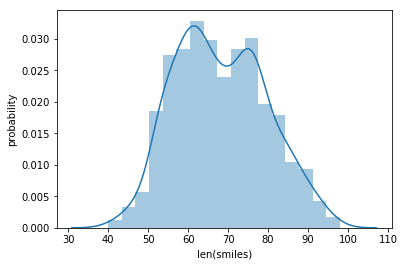

In [83]:
smiles_lens = [len(sm) for sm in df['Molecule SMILES']]
sns.distplot(smiles_lens)
plt.xlabel('len(smiles)')
plt.ylabel('probability')

### Process SMILES

In [0]:
# Setup
pp = pd.DataFrame()                                              # New dataframe 
pp[['ID','Smiles']] = df[['External_ID','Molecule SMILES']]      # Rename headers
pp['ProblematicSmiles'] = pd.Series()                            # Create a new column for SMILES \
                                                                 # that can't be parsed with RDKit

In [0]:
# Some of the SMILE strings will not be parsed by RDKit \
# it is reasonable to expect artifacts from the csv file encoding \
# or errors on the dataset

def smile2mol(smile):
    '''Convert SMILES string to 
       RDKit Mol obj, if the conversion
       fails then return "None"
    
       Keyword arguments:
       smile -- SMILE string
    '''
    try:
        mol = Chem.MolFromSmiles(smile)
    except:
        return None
    else:
        return mol

In [29]:
# Convert SMILES to Mol objects 
pp['Molecule'] = pp['Smiles'].apply(lambda x: smile2mol(x))

RDKit ERROR: [18:32:47] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3ncc(s3)C=O)Cl)Cl'
RDKit ERROR: [18:32:47] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)OCC=C)C(=O)NCCOC)Cl)Cl'
RDKit ERROR: [18:32:47] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)C(=O)NCCOC)Cl)Cl'
RDKit ERROR: [18:32:47] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)OC)C(=O)NC)Cl)Cl'
RDKit ERROR: [18:32:47] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)C(=O)NC)Cl)Cl'
RDKit ERROR: [18:32:47] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)c4nccn4COC)Cl)Cl'
RDKit ERROR: [18:32:47] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)c4[nH]ccn4)Cl)Cl'
RDKit ERROR: [18:32:47] SMILE

We can see there are indeed problematic SMILES. When copying and pasting those strings on RDKit directly, I realized the error can be fixed if the string `NC\2CCN` are replaced with `NC2CCN`. This is an _ad-hoc_ solution, that should be made automatic.

In [42]:
# Count problematic SMILES
problematics = [ k for k,v in enumerate(pp['Molecule']) if v is None ]

# Flags these SMILES in the working dataframe
pp['ProblematicSmiles'] = pp['Smiles'].loc[problematics]
  
# Fix SMILES
for sm in range(len(problematics)):
    # problematic SMILE row number
    ix = problematics[sm]  
    
    # Replace character "\2" with "2"
    pp['Smiles'] = pp['Smiles'].str.replace('\2','2', regex=True)
    
    # Redo smile2mol conversion
    pp['Molecule'] = pp['Smiles'].apply(lambda x: smile2mol(x))
    
# Check all went smooth
if not pp['Molecule'].isnull().all().all():
    print("Hey!!! It's FIXED :-)")

Hey!!! It's FIXED :-)


Molecular Descriptors
------------------

The next step should be to translate each compound into a vectorial format that can be understood by statistical learning techniques, e.g. _random forest_, or _neural networks_. `RDKit` molecular descriptors, e.g. molecular weight, atom partial charges, etc, are a way to transform the chemical information containd in the SMILE string into a feature vector. This process is commonly called __featurization__.

*Note: add also Morgan fingerprints.*

### Compute Descriptors

In [0]:
# Molecular descriptors can be obtained from \
# the Mol objects using rdkit.ML.Descriptors.MoleculeDescriptors module

descriptors = list(np.array(Descriptors._descList)[:,0])                        # descriptor list
ccalculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors)    # calculating descriptors

In [0]:
# Make is easier to identify errors or \
# problematic values, e.g infity descriptor values
def computeDescriptors(mol, ccalculator):
    '''Calculate Molecular descriptors from 
       RDKit Mol object, if the calculation
       fails then return "None"
    
       Keyword arguments:
       mol -- RDKit Mol object
    '''
    try:
        features = np.array(ccalculator.CalcDescriptors(mol))
    except:
        return None
    else:
        if not np.all(np.isfinite(features)):
            print("Caution! Infinite value")
            return None
        else:
            return features

In [45]:
# Selecting only non-null molecules 
pp = pp[ pp["Molecule"].notnull() ]

# Mapping descriptors with molecules
ff = lambda x: computeDescriptors(x, ccalculator)
pp['Descriptors'] = pp['Molecule'].map(ff)

# Flag problems
problematics = pp["Descriptors"].isnull()
print("{} molecules failed to get descriptors".format(problematics.sum())) 

0 molecules failed to get descriptors


In [51]:
# Convert descripor list to dataframe
tmpdess = pp["Descriptors"].apply(pd.Series)

# Make headers the descriptor names
tmpdess = tmpdess.rename(columns = lambda x : descriptors[x])

# Check first 5 rows
tmpdess.head(5)

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.198481,-0.435597,12.198481,0.013283,0.623001,384.223,369.103,383.055195,132.0,0.0,0.311075,-0.350740,0.350740,0.311075,1.400000,2.120000,2.720000,1.606288,782.714558,17.974327,13.037493,14.549351,11.952397,7.646576,8.402505,5.682961,6.468125,4.062271,4.755185,2.799838,3.112547,-2.32,5.332598e+05,17.501340,7.283006,3.853433,152.831853,15.200677,10.847038,0.0,5.817863,5.90718,5.687386,14.908855,4.983979,0.000000,0.0,23.201880,24.974377,31.394564,9.945944,9.717848,40.614309,0.000000,15.284746,0.0,18.883484,17.989423,50.379934,0.0,0.000000,10.216698,11.505249,0.0,23.201880,39.929801,0.000000,10.114318,23.330108,24.395945,10.175743,0.000000,0.0,104.16,4.923311,14.908855,0.0,22.789517,42.465580,0.000000,18.329578,6.066367,4.899910,15.284746,23.201880,0.0,11.639059,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,54.916497,0.333333,25.0,2.0,8.0,0.0,1.0,1.0,0.0,2.0,2.0,5.0,2.0,10.0,4.0,0.0,1.0,1.0,3.0,3.02350,94.4053,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.517532,-0.411106,12.517532,0.011515,0.550709,436.310,414.134,435.090602,144.0,0.0,0.311075,-0.353241,0.353241,0.311075,1.444444,2.148148,2.740741,1.607439,843.272683,19.551677,15.236879,16.822875,12.863081,8.900969,9.693967,6.937354,7.791691,4.712163,5.368251,3.261192,4.047073,-2.42,1.314876e+06,19.344590,8.077319,4.292290,165.187695,15.200677,5.693928,0.0,5.817863,5.90718,5.

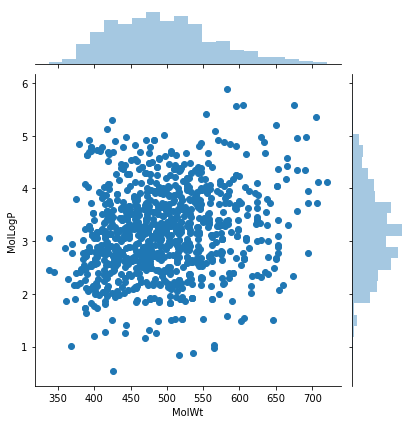

In [94]:
# Molecular weight versus Partition coefficient (octanol/water)
sns.jointplot('MolWt', 'MolLogP', data=tmpdess)

In [0]:
# Concatenating Mol, IC50 and descriptor dataframes
final_dataset = pd.concat([pp[["ID", "Smiles"]], df["SAU Gyr IC50 (µM)"], tmpdess], axis=1)
final_dataset = final_dataset.rename(columns={"SAU Gyr IC50 (µM)":"IC50"})
final_dataset = final_dataset.dropna(how ='any')

### Data cleaning

Finally we have a feature dataset with the compounds information in a vector form, ready for prime time. But before anything else, we have to evaluate which descriptors are correlated, and we should get rid of descriptor $\text{IPC}$ (the magnitude of this feature is insane, e.g. $\sim 10^5$) and those columns with all values $0$.

In [0]:
final_dataset = final_dataset.drop(['Ipc'], axis=1)       # Drop IPC!!!!

headers = list(final_dataset.head(1))                     # Get column names
for col in headers[1:]:                                   # Drop empty columns
    if final_dataset[col].sum() == 0:
        final_dataset = final_dataset.drop([col], axis=1)

Remove correlated descriptors

In [0]:
# Create correlation matrix
corr_matrix = final_dataset.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
for col in to_drop:
    final_dataset.drop(col, axis=1, inplace=True)

In [64]:
# How many descriptors were removed
old = len(descriptors)
new = len(list(final_dataset.head(1))[3:])
print("%i descriptors were removed" % (old - new))

# Update descriptors list
descriptors = list(final_dataset.head(1))[3:]

35 descriptors were removed


The Qualifiers dilema
-------------------------

Now it is time to combine the features and the prediction targets, the $\text{IC50}$s. This dataset includes experimental mesurements from different studies, which in itself it's a challenge if you can to predict $\log{\text{IC50}}$s. But, more importantly we don't have accurate measurements for all compunds in the datatset, amnye of the reported affinities have qualifiers, like $>400\; \mu M$. For now, let's deal with this problem by ignoring it :-O

In [0]:
# Comment this latter
pattern = "[><]"
filters = final_dataset.IC50.str.contains(pattern)
final_dataset = final_dataset[~filters]

Log-transform $\text{IC50}$ values

In [0]:
final_dataset['IC50'] = final_dataset['IC50'].apply(lambda x: np.log(float(x)))

Save clean dataset in `Google Drive`.

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
# Save in Google Drive
final_dataset.to_csv('/content/drive/My Drive/Hack 7/Gyrase/AZ_clean_test.csv')

Machine Learning
---------------------

Here _Random Forest_ and _Deep Neural Network_ will be used to generated a predictive model for Gyrase inhibitors $\log{\text{IC50}}$ as a function of these ligands molecular properties.



In [104]:
featurizer = dc.feat.UserDefinedFeaturizer(descriptors)    # custom features
dataloader = dc.data.UserCSVLoader(tasks=["IC50"], 
                               smiles_field="Smiles", 
                               id_field="ID", 
                               featurizer=featurizer,
                               verbose=True)               # DeepChem loader class 


filepath = "/content/drive/My Drive/Hack 7/Gyrase/AZ_clean_test.csv"   # Google Drive path
deepdata = dataloader.featurize(filepath)                              # DeepChem dataset

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /content/drive/My Drive/Hack 7/Gyrase/AZ_clean_test.csv
Loading shard 1 of size 8192.
TIMING: user specified processing took 0.035 s
TIMING: featurizing shard 0 took 0.046 s
TIMING: dataset construction took 0.097 s
Loading dataset from disk.


/usr/local/lib/python3.6/site-packages/deepchem/data/data_loader.py:126: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X_shard = df.as_matrix(columns=featurizer.feature_fields)


Split the machine-learning-ready dataset into __training__, __test__ and __validation__ subsets.

In [105]:
splitter = dc.splits.RandomSplitter(deepdata)                                       
train, valid, test = splitter.train_valid_test_split(deepdata,
                                                     frac_train=.7,
                                                     frac_valid=.1,
                                                     frac_test =.2)

Computing train/valid/test indices
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.008 s
Loading dataset from disk.
TIMING: dataset construction took 0.009 s
Loading dataset from disk.


The performance of common machine-learning algorithms can be very sensitive to preprocessing of the data, neural networks mostly. Here we will normalize the features and $\log{\text{IC50}}$ to have zero-mean and unit-standard-deviation, using `deepchem`.

In [106]:
transformers = [
    dc.trans.NormalizationTransformer(transform_y=True, dataset=train)]

for dataset in [train, valid, test]:
    for transformer in transformers:
        dataset = transformer.transform(dataset)

TIMING: dataset construction took 0.013 s
Loading dataset from disk.
TIMING: dataset construction took 0.006 s
Loading dataset from disk.
TIMING: dataset construction took 0.007 s
Loading dataset from disk.


### Random Forest

Fit the RF model using the training set

In [0]:
sklearn_model = RFR(n_estimators=100)
model = dc.models.SklearnModel(sklearn_model)
model.fit(train)

Evaluate the model on the __test__ set using the Mean-Squared Error and $R^2$ scores of the predictions against the target values.

In [0]:
%%capture

# MSE
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
train_scores = model.evaluate(train, [metric], transformers)
test_scores  = model.evaluate(test,  [metric], transformers)

In [120]:
print("MSE train scores {}".format(train_scores['mean_squared_error']))
print("MSE test  scores {}".format(test_scores['mean_squared_error']))

MSE train scores 2.6097867571197675
MSE test  scores 12.6937611163767


In [0]:
%%capture

# R2
metric = dc.metrics.Metric(dc.metrics.r2_score)
train_scores = model.evaluate(train, [metric], transformers)
test_scores  = model.evaluate(test,  [metric], transformers)

In [122]:
print("R2 train scores {}".format(train_scores['r2_score']))
print("R2 test  scores {}".format(test_scores['r2_score']))

R2 train scores 0.922928957720113
R2 test  scores 0.6302149779099391


The performance of this basic _Random Forest_ model isn’t very strong. To construct stronger models, let’s attempt to optimize the hyperparameters  to achieve better performance. 

In [129]:
def rf_model_builder(model_params, model_dir):
    sklearn_model = RFR(**model_params)
    return dc.models.SklearnModel(sklearn_model, model_dir)

params_dict = {
    "n_estimators": [20, 100],
    "max_features": ["auto", "log2", None],
    "n_jobs": [2]
}


metric    = dc.metrics.Metric(dc.metrics.mean_squared_error)
optimizer = dc.hyper.HyperparamOpt(rf_model_builder)

best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train, test, transformers, metric=metric)

Fitting model 1/6
hyperparameters: {'n_estimators': 20, 'max_features': 'auto', 'n_jobs': 2}
computed_metrics: [14.261436928561668]
Model 1/6, Metric mean_squared_error, Validation set 0: 14.261437
	best_validation_score so far: 14.261437
Fitting model 2/6
hyperparameters: {'n_estimators': 20, 'max_features': 'log2', 'n_jobs': 2}
computed_metrics: [13.663340488767483]
Model 2/6, Metric mean_squared_error, Validation set 1: 13.663340
	best_validation_score so far: 14.261437
Fitting model 3/6
hyperparameters: {'n_estimators': 20, 'max_features': None, 'n_jobs': 2}
computed_metrics: [12.693998200889762]
Model 3/6, Metric mean_squared_error, Validation set 2: 12.693998
	best_validation_score so far: 14.261437
Fitting model 4/6
hyperparameters: {'n_estimators': 100, 'max_features': 'auto', 'n_jobs': 2}
computed_metrics: [12.11617909371505]
Model 4/6, Metric mean_squared_error, Validation set 3: 12.116179
	best_validation_score so far: 14.261437
Fitting model 5/6
hyperparameters: {'n_estimat

No better than before. So let's try the Neural Network.

### Neural Network

In [0]:
# GPU info
# !nvidia-smi

In [0]:
%%capture

params_dict = {"learning_rate": np.power(10., np.random.uniform(-5, -3, size=1)),
               "decay": np.power(10, np.random.uniform(-6, -4, size=1)),
               "nb_epoch": [1500] }

n_features = train.get_data_shape()[0]

def model_builder(model_params, model_dir):
    model = dc.models.MultitaskRegressor(
        1, n_features, layer_sizes=[2000,1000,1000,500], dropouts=[.25],
        batch_size=50, **model_params)
    return model

optimizer = dc.hyper.HyperparamOpt(model_builder)

best_dnn, best_dnn_hyperparams, all_dnn_results = optimizer.hyperparam_search(
    params_dict, train, test, transformers, metric=metric)

In [0]:
# Get MSE of DNN

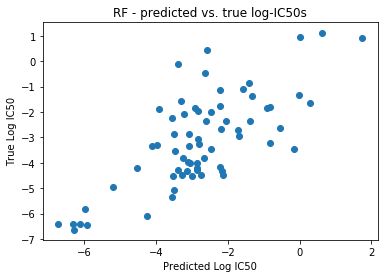

In [136]:
#sns.jointplot('MolWt', 'MolLogP', data=tmpdess)
predicted_test = best_rf.predict(valid)
true_test = valid.y
plt.scatter(predicted_test, true_test)
plt.xlabel('Predicted Log IC50')
plt.ylabel('True Log IC50')
plt.title(r'RF - predicted vs. true log-IC50s')
plt.show()

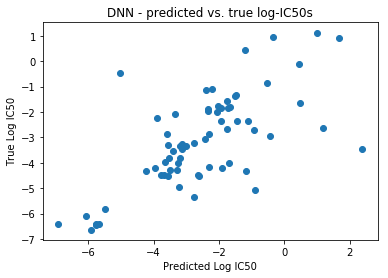

In [137]:
predicted_test = best_dnn.predict(valid)
true_test = valid.y
plt.scatter(predicted_test, true_test)
plt.xlabel('Predicted Log IC50')
plt.ylabel('True Log IC50')
plt.title(r'DNN - predicted vs. true log-IC50s')
plt.show()